In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import pprint
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

pd.options.display.float_format = '{:.3f}'.format

### <font color="orange">  **Data Loading and Visualizaiton** </font>

In [2]:
df = pd.read_csv('health_insurance_train.csv')
df_autograder = pd.read_csv('health_insurance_autograde.csv')
                            
display(df.iloc[8:16])
display(df_autograder.iloc[8:16])

,whrswk,hhi,whi,hhi2,education,race,hispanic,experience,kidslt6,kids618,husby,region
8,5.00,yes,no,yes,13-15years,NaN,no,20.00,1.00,1.00,53.00,south
9,40.00,no,yes,yes,12years,white,no,9.00,1.00,1.00,18.00,west
10,40.00,no,no,no,12years,white,no,33.00,0.00,0.00,0.00,other
11,40.00,no,no,no,9-11years,white,no,5.50,1.00,0.00,20.00,northcentral
12,35.00,no,yes,no,12years,NaN,yes,26.00,0.00,1.00,0.00,south
13,45.00,no,yes,yes,16years,white,no,7.00,0.00,0.00,40.00,south
14,0.00,yes,no,yes,12years,white,no,38.00,0.00,0.00,0.00,other
15,20.00,yes,no,yes,12years,white,no,9.00,1.00,1.00,33.00,south


,hhi,whi,hhi2,education,race,hispanic,experience,kidslt6,kids618,husby,region
8,yes,yes,yes,13-15years,white,no,35.00,0.00,0.00,52.86,south
9,no,yes,no,16years,white,no,1.00,0.00,0.00,5.00,northcentral
10,no,no,no,12years,white,no,14.00,NaN,NaN,0.00,northcentral
11,no,yes,no,12years,white,no,44.00,NaN,NaN,0.00,west
12,no,yes,yes,13-15years,white,no,23.00,0.00,3.00,45.00,west
13,no,yes,no,16years,white,no,10.00,0.00,0.00,0.00,south
14,yes,no,yes,>16years,white,no,23.00,0.00,0.00,40.10,west
15,yes,no,yes,12years,white,no,22.00,1.00,0.00,24.85,other


In [61]:
def preprocess_1(df):
    # turns all data numeric except regions
    education_mapping = {
        '<9years': 8,      # Assume '<9years' corresponds to 8 years
        '9-11years': 10,   # Midpoint for '9-11years'
        '12years': 12,     # Exact number of years
        '11-13years': 12,  # Midpoint for '11-13years'
        '13-15years': 14,  # Midpoint for '13-15years'
        '16years': 16,     # Exact number of years
        '>16years': 18     # Assume '>16years' corresponds to 17 years
    }
    
    yn_mapping = {'yes': 1, 'no': 0}
    race_mapping = {'white': 1, 'black': 0}
    
    df['education'] = df['education'].map(education_mapping)
    df['race'] = df['race'].map(race_mapping).fillna(0.5)
    
    binary_columns = ['hhi', 'whi', 'hhi2', 'hispanic']
    for col in binary_columns:
        df[col] = df[col].map(yn_mapping)
    
    df['kidslt6'] = df['kidslt6'].fillna(df['kidslt6'].median())
    df['kids618'] = df['kids618'].fillna(df['kids618'].median())
    
    
    display(df.iloc[8:16])
    return df

In [55]:
def visualize_data(df):
    # 1. Histograms
    df.hist(figsize=(12, 8), bins=10, color='skyblue', edgecolor='black')
    plt.suptitle('Histograms of dfset Features')
    plt.tight_layout()
    plt.show()
    
    # 2. Pairplot - Showing pairwise relationships
    # sns.pairplot(df)
    # plt.suptitle('Pairwise Plot of Features')
    # plt.show()
    
    # 3. Correlation heatmap
    data = df.drop('region', axis=1)
    plt.figure(figsize=(10, 6))
    sns.heatmap(data.corr(), annot=True, cmap='coolwarm', linewidths=0.5)
    plt.title('Correlation Heatmap of Features')
    plt.show()

In [62]:
df = preprocess_1(df)

,whrswk,hhi,whi,hhi2,education,race,hispanic,experience,kidslt6,kids618,husby,region
8,5.00,1,0,1,14,0.50,0,20.00,1.00,1.00,53.00,south
9,40.00,0,1,1,12,1.00,0,9.00,1.00,1.00,18.00,west
10,40.00,0,0,0,12,1.00,0,33.00,0.00,0.00,0.00,other
11,40.00,0,0,0,10,1.00,0,5.50,1.00,0.00,20.00,northcentral
12,35.00,0,1,0,12,0.50,1,26.00,0.00,1.00,0.00,south
13,45.00,0,1,1,16,1.00,0,7.00,0.00,0.00,40.00,south
14,0.00,1,0,1,12,1.00,0,38.00,0.00,0.00,0.00,other
15,20.00,1,0,1,12,1.00,0,9.00,1.00,1.00,33.00,south


In [63]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   whrswk      5000 non-null   float64
 1   hhi         5000 non-null   int64  
 2   whi         5000 non-null   int64  
 3   hhi2        5000 non-null   int64  
 4   education   5000 non-null   int64  
 5   race        5000 non-null   float64
 6   hispanic    5000 non-null   int64  
 7   experience  5000 non-null   float64
 8   kidslt6     5000 non-null   float64
 9   kids618     5000 non-null   float64
 10  husby       5000 non-null   float64
 11  region      5000 non-null   object 
dtypes: float64(6), int64(5), object(1)
memory usage: 468.9+ KB


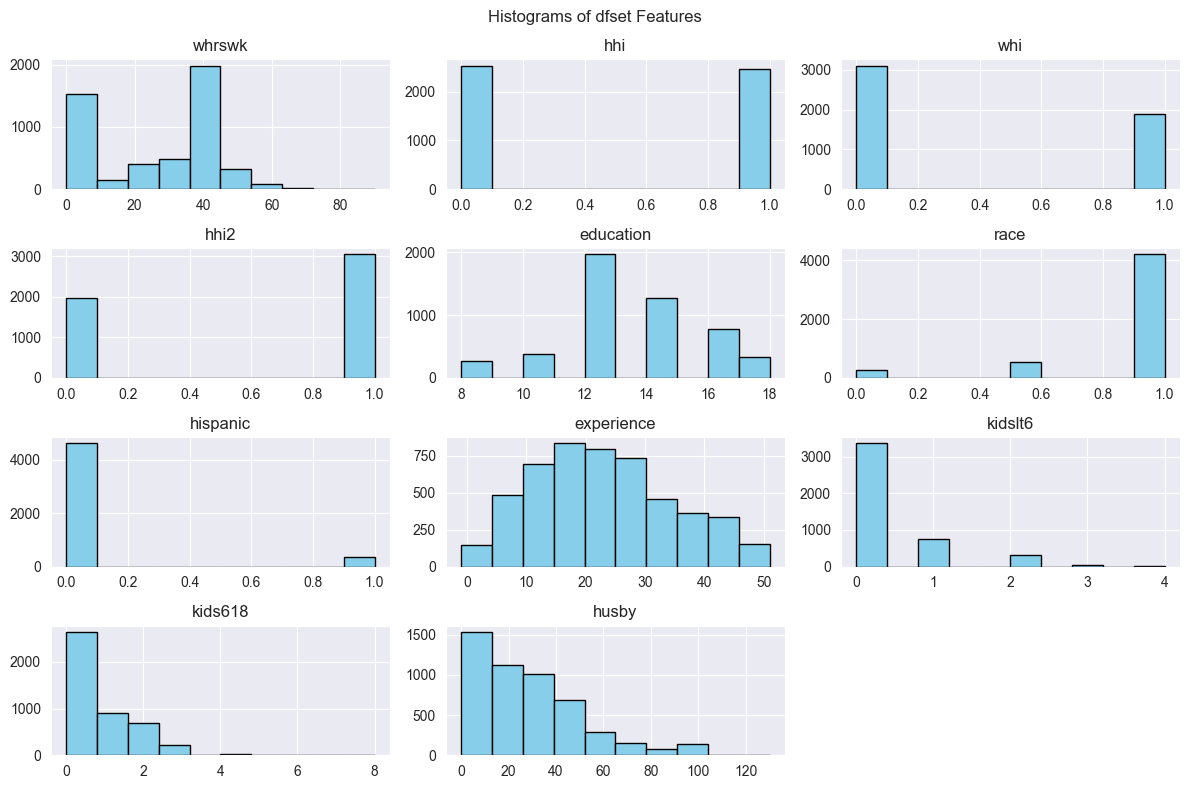

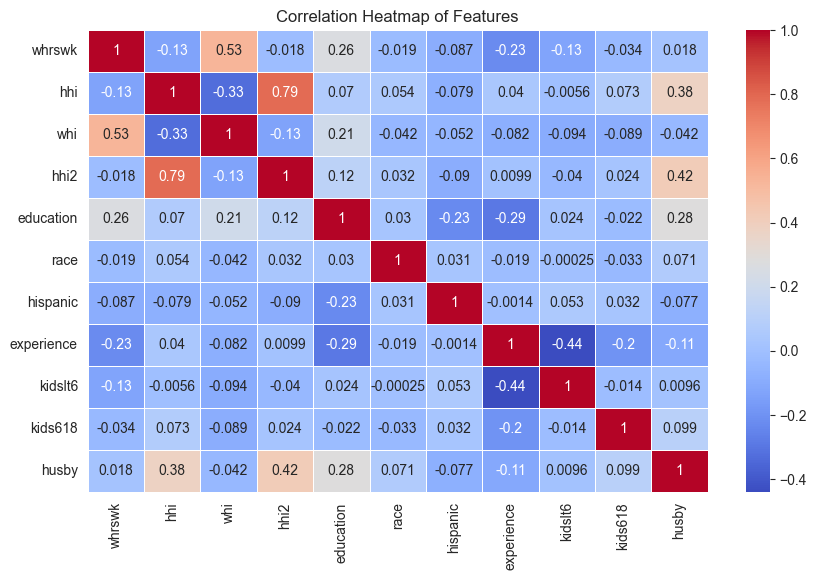

In [51]:
visualize_data(df)

In [ ]:
df_autograder = preprocess_1(df_autograder)

In [36]:

# race_counts = df['race'].value_counts()
# race_counts_autograder = df_autograder['race'].value_counts()
# print(race_counts, race_counts_autograder)

,hhi,whi,hhi2,education,race,hispanic,experience,kidslt6,kids618,husby,region
8,1,1,1,14,1.00,0,35.00,0.00,0.00,52.86,south
9,0,1,0,16,1.00,0,1.00,0.00,0.00,5.00,northcentral
10,0,0,0,12,1.00,0,14.00,NaN,NaN,0.00,northcentral
11,0,1,0,12,1.00,0,44.00,NaN,NaN,0.00,west
12,0,1,1,14,1.00,0,23.00,0.00,3.00,45.00,west
13,0,1,0,16,1.00,0,10.00,0.00,0.00,0.00,south
14,1,0,1,18,1.00,0,23.00,0.00,0.00,40.10,west
15,1,0,1,12,1.00,0,22.00,1.00,0.00,24.85,other


race
1.00    4202
0.50     537
0.00     261
Name: count, dtype: int64 race
1.00    14574
0.50     1839
0.00      859
Name: count, dtype: int64


In [3]:
''''
* Data visualization (Edlyn)
- Make nice histograms of the features and the target
- Make a covariance matrix of the features
'''

"'\n* Data visualization (Edlyn)\n- Make nice histograms of the features and the target\n- Make a covariance matrix of the features\n"

### <font color="orange">  **Data processing fucntions** </font>

In [ ]:
preprocessor_standard = ColumnTransformer(transformers=[
    ('num', Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ]), ['experience', 'kidslt6', 'kids618', 'husby']),
    
    ('education', Pipeline(steps=[
        ('mapper', FunctionTransformer(map_columns)),
        ('scaler', StandardScaler())
    ]), ['education']),
    
    ('yn_columns', FunctionTransformer(map_columns), ['hhi', 'whi', 'hhi2', 'hispanic']),
    
    # Race column (mapping categories to ints and imputing missing with 0.5)
    ('race', Pipeline(steps=[
        ('mapper', FunctionTransformer(map_race_to_int)),  # Map 'white' -> 1, 'black' -> 0
    ]), ['race']),
    
    # Categorical columns pipeline (most frequent imputation and one-hot encoding)
    ('onehot', Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),  # Handle NaN in categorical columns
        ('encoder', OneHotEncoder(drop='first'))
    ]), ['region'])
])

preprocessor_poly = ColumnTransformer(transformers=[
    ('num', Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('poly', PolynomialFeatures(degree=2, include_bias=False)),  # Apply polynomial features
        ('scaler', StandardScaler())  # Apply scaler after polynomial features
    ]), ['experience', 'kidslt6', 'kids618', 'husby']),
    
    ('education', Pipeline(steps=[
        ('mapper', FunctionTransformer(map_columns)),
        ('poly', PolynomialFeatures(degree=2, include_bias=False)),  # Apply polynomial features
        ('scaler', StandardScaler())  # Apply scaler after polynomial features
    ]), ['education']),
    
    ('yn_columns', FunctionTransformer(map_columns), ['hhi', 'whi', 'hhi2', 'hispanic']),
    
    ('race', Pipeline(steps=[
        ('mapper', FunctionTransformer(map_race_to_int)),  # Map 'white' -> 1, 'black' -> 0
    ]), ['race']),
    
    # Categorical columns pipeline (most frequent imputation and one-hot encoding)
    ('onehot', Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),  # Handle NaN in categorical columns
        ('encoder', OneHotEncoder(drop='first'))
    ]), ['region'])
])

In [4]:
''''
* Create the data pipeline functions (Edlyn)

- Preprocess data (PIPE 1, PIPE 2)
    . Apply one hot encoding for region, race and hispanic. Make a column for race_nan and hispanic_nan. 
      People that decide to not fill these information might have a characteristic profile. So we can let the
      model decide if it is important or not.

    . Make remaining yes/no 1 and -1 (helps KNN, since the features are logically opoosite of each other)

    . Make True/False 1 and 0 (When it is not just about "yes/no" give 1 to True and 0 to False)

    . Process education column, nan becomes average 

    . You can apply remove first if you want


- Regular scaling (PIPE 1) 

- Selective scaling (PIPE 2)

- Data filtering with mahalanobis (PIPE 2)

'''


'\'\n* Create the data pipeline functions (Edlyn)\n\n- Preprocess data (PIPE 1, PIPE 2)\n    . Apply one hot encoding for region, race and hispanic. Make a column for race_nan and hispanic_nan. \n      People that decide to not fill these information might have a characteristic profile. So we can let the\n      model decide if it is important or not.\n\n    . Make remaining yes/no 1 and -1 (helps KNN, since the features are logically opoosite of each other)\n\n    . Make True/False 1 and 0 (When it is not just about "yes/no" give 1 to True and 0 to False)\n\n    . Process education column, nan becomes average \n\n    . You can apply remove first if you want, but I we should verify if it helps\n\n\n- Regular scaling (PIPE 1) \n\n- Selective scaling (PIPE 2)\n\n- Data filtering with mahalanobis (PIPE 2)\n\n'

### <font color="orange">  **Pipeline creation** </font>

In [5]:
df_1 = pd.read_csv('health_insurance_train_processed.csv')# Use the pipiline 1 function function instead of this file

display(df_1.iloc[9:30])

,whrswk,hhi,whi,hhi2,education,experience,kidslt6,kids618,husby,race_black,race_other,race_white,race_nan,reg_northcentral,reg_other,reg_south,reg_west,hisp_no,hisp_yes
9,0.766,-1,1,1,-0.401,-1.201,1.074,0.313,-0.392,0,0,1,0,0,0,0,1,1,0
10,0.766,-1,-1,-1,-0.401,0.875,-0.549,-0.746,-1.150,0,0,1,0,0,1,0,0,1,0
11,0.766,-1,-1,-1,-1.158,-1.504,1.074,-0.746,-0.308,0,0,1,0,1,0,0,0,1,0
12,0.499,-1,1,-1,-0.401,0.269,-0.549,0.313,-1.150,0,0,0,1,0,0,1,0,0,1
13,1.033,-1,1,1,1.112,-1.374,-0.549,-0.746,0.535,0,0,1,0,0,0,1,0,1,0
14,-1.372,1,-1,1,-0.401,1.307,-0.549,-0.746,-1.150,0,0,1,0,0,1,0,0,1,0
15,-0.303,1,-1,1,-0.401,-1.201,1.074,0.313,0.240,0,0,1,0,0,0,1,0,1,0
16,-1.372,1,-1,1,-0.401,-1.720,0.000,-0.000,-0.966,1,0,0,0,0,0,0,1,1,0
17,0.766,-1,1,1,-0.401,0.615,-0.549,-0.746,1.378,0,0,1,0,0,1,0,0,0,1
18,-1.372,1,-1,1,0.355,0.961,-0.549,-0.746,3.064,0,0,1,0,0,1,0,0,1,0


In [61]:
df_2 = pd.read_csv('health_insurance_train_processed.csv') # Use the pipiline 2 function instead of this file

display(df_2.iloc[9:30])

,whrswk,hhi,whi,hhi2,education,experience,kidslt6,kids618,husby,race_black,race_other,race_white,race_nan,reg_northcentral,reg_other,reg_south,reg_west,hisp_no,hisp_yes
9,0.766,-1,1,1,-0.401,-1.201,1.074,0.313,-0.392,0,0,1,0,0,0,0,1,1,0
10,0.766,-1,-1,-1,-0.401,0.875,-0.549,-0.746,-1.150,0,0,1,0,0,1,0,0,1,0
11,0.766,-1,-1,-1,-1.158,-1.504,1.074,-0.746,-0.308,0,0,1,0,1,0,0,0,1,0
12,0.499,-1,1,-1,-0.401,0.269,-0.549,0.313,-1.150,0,0,0,1,0,0,1,0,0,1
13,1.033,-1,1,1,1.112,-1.374,-0.549,-0.746,0.535,0,0,1,0,0,0,1,0,1,0
14,-1.372,1,-1,1,-0.401,1.307,-0.549,-0.746,-1.150,0,0,1,0,0,1,0,0,1,0
15,-0.303,1,-1,1,-0.401,-1.201,1.074,0.313,0.240,0,0,1,0,0,0,1,0,1,0
16,-1.372,1,-1,1,-0.401,-1.720,0.000,-0.000,-0.966,1,0,0,0,0,0,0,1,1,0
17,0.766,-1,1,1,-0.401,0.615,-0.549,-0.746,1.378,0,0,1,0,0,1,0,0,0,1
18,-1.372,1,-1,1,0.355,0.961,-0.549,-0.746,3.064,0,0,1,0,0,1,0,0,1,0


In [62]:
# Split the data into seen and unseen while keeping it as a pandas dataframe
fraction = 0.2  # 20% of the rows

#-------------------PIPE 1-------------------
df_unseen_1 = df_1.sample(frac = fraction, random_state=42) # Get 20% of random rows
df_seen_1 = df_1.drop(df_unseen_1.index) # Get the remaining 80% of the rows

X_seen_1 = df_seen_1.iloc[:, 1:]
Y_seen_1 = df_seen_1.iloc[:, 0]

X_unseen_1 = df_unseen_1.iloc[:, 1:]
Y_unseen_1 = df_unseen_1.iloc[:, 0]

#-------------------PIPE 2-------------------
df_unseen_2 = df_2.sample(frac = fraction, random_state=42)
df_seen_2 = df_2.drop(df_unseen_2.index)

X_seen_2 = df_seen_2.iloc[:, 1:]
Y_seen_2 = df_seen_2.iloc[:, 0]

X_unseen_2 = df_unseen_2.iloc[:, 1:]
Y_unseen_2 = df_unseen_2.iloc[:, 0]


### <font color="orange">  **Training Functions** </font>

In [63]:

#-------------------Dummy-------------------
from sklearn.dummy import DummyRegressor
def train_dummy_predictor(X, Y):
    model = DummyRegressor(strategy='mean')
    model.fit(X, Y)
    return model

#-------------------KNN-------------------
from sklearn.neighbors import KNeighborsRegressor
def train_knn_regressor(X, Y, param_grid):
    model = KNeighborsRegressor(**param_grid)
    model.fit(X, Y)
    Y_pred = model.predict(X)
    loss_values = [mean_absolute_error(Y, Y_pred)]
    return model,loss_values

#-------------------SGD-------------------
from sklearn.linear_model import SGDRegressor
def train_sgd_regressor(X, Y, params):
    model = SGDRegressor(**params)
    epochs = params['max_iter']

    loss_values = []
    for epoch in range(epochs):
        model.partial_fit(X, Y)
        Y_pred = model.predict(X)
        epoch_loss = mean_absolute_error(Y, Y_pred)
        loss_values.append(epoch_loss)
    
    return model, loss_values

#-----------Decision Tree-------------------
from sklearn.tree import DecisionTreeRegressor
def train_decision_tree_regressor(X, Y, params):

    '''params : dict
        Dictionary of parameters to pass to DecisionTreeRegressor.'''
    
    # splitter = Supported strategies are "best" to choose the best split and "random" to choose the best random split.
    # max_features = The number of features to consider when looking for the best split
    # min_samples_split = The minimum number of samples required to split an internal node
    # min_samples_leaf = The minimum number of samples required to be at a leaf node

    model = DecisionTreeRegressor(**params,random_state = 42)
    loss_values = []
    
    # Custom training loop with logging
    for depth in range(1, params['max_depth'] + 1):
        model.set_params(max_depth=depth)
        model.fit(X, Y)
        Y_pred = model.predict(X)
        loss = mean_absolute_error(Y, Y_pred)
        loss_values.append(loss)
    
    return model, loss_values


### <font color="orange">  **Logistic Adjustment** </font>

In [64]:
def soft_max_adjustnent(value, target1 = -1.372319745743416, target2= 0.765866095571318 , gamma=5):
    # Calculate the distance to each target
    dist_to_target1 = abs(value - target1)
    dist_to_target2 = abs(value - target2)
    
    # Transform the distance to probability
    # Assumed the distance follows a Exponential distribution
    prob_target1 = np.exp(-gamma * dist_to_target1)
    prob_target2 = np.exp(-gamma * dist_to_target2)
    
    # Normalize the probabilities using soft max
    total_prob = prob_target1 + prob_target2
    prob_target1 /= total_prob
    prob_target2 /= total_prob
    
    # Adjust the value based on the probabilities
    adjusted_value = prob_target1 * target1 + prob_target2 * target2
    
    return adjusted_value

### <font color="orange">  **Create model dict and test dataframe** </font>

In [65]:

#----------Creation of models dict-----------
models_dict_1 = {'KNN': None, 'SGD': None, 'Tree':None}
models_dict_2 = {'KNN': None, 'SGD': None, 'Tree':None}

for key in models_dict_1:
    models_dict_1[key] = {'defalt' :None, 'best_param':None, 'best_model' :None, 'ensemble':None, 'best_ensemble':None}
    models_dict_2[key] = {'defalt' :None, 'best_param':None, 'best_model' :None, 'ensemble':None, 'best_ensemble':None}

#----------Creation of test dfs-----------
test_df_1 = pd.DataFrame(index=['D','T','TA','ET','BET','BETA'],columns=['KNN','SGD','Tree'])
test_df_2 = pd.DataFrame(index=['D','T','TA','ET','BET','BETA'],columns=['KNN','SGD','Tree'])

### <font color="orange">  **Store and test default models** </font>

In [66]:
####################################################################
# ------ KNN REGRESSOR
print("------ KNN Regressor -----")
model = KNeighborsRegressor()
model.fit(X_seen_1, Y_seen_1)
models_dict_1['KNN']['defalt'] = model
test_df_1.loc['D','KNN'] = mean_absolute_error(Y_unseen_1, model.predict(X_unseen_1))

model = KNeighborsRegressor()
model.fit(X_seen_2, Y_seen_2)
models_dict_2['KNN']['defalt'] = model
test_df_2.loc['D','KNN'] = mean_absolute_error(Y_unseen_2, model.predict(X_unseen_2))


####################################################################
# ------ SGD REGRESSOR
print("------ SGD Regressor -----")
model = SGDRegressor()
model.fit(X_seen_1, Y_seen_1)
models_dict_1['SGD']['defalt'] = model
test_df_1.loc['D','SGD'] = mean_absolute_error(Y_unseen_1, model.predict(X_unseen_1))

model = SGDRegressor()
model.fit(X_seen_2,  Y_seen_2)
models_dict_2['SGD']['defalt'] = model
test_df_2.loc['D','SGD'] = mean_absolute_error(Y_unseen_2, model.predict(X_unseen_2))

####################################################################
# ------ DECISION TREE REGRESSOR
print("------ Decision Tree Regressor -----")
model = DecisionTreeRegressor()
model.fit(X_seen_1, Y_seen_1)
models_dict_1['Tree']['defalt'] = model
test_df_1.loc['D','Tree'] = mean_absolute_error(Y_unseen_1, model.predict(X_unseen_1))

model = DecisionTreeRegressor()
model.fit(X_seen_2, Y_seen_2)
models_dict_2['Tree']['defalt'] = model
test_df_2.loc['D','Tree'] = mean_absolute_error(Y_unseen_2, model.predict(X_unseen_2))


------ KNN Regressor -----
------ SGD Regressor -----
------ Decision Tree Regressor -----


### <font color="orange">  **Perform grid search, test, store best models and parameters** </font>

In [69]:

def grid_search(X, Y, model, param_grid, cv=5):
    
    # cv = It determines the cross-validation splitting strategy used to evaluate the performance of the model for each combination of hyperparameters
    # This means that the dataset will be split into 5 parts (folds). The model will be trained on 4 parts and tested on the remaining part.
    # This process will be repeated 5 times, each time with a different part as the test set.
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
    
    # Fit the model
    print("Working on grid search")
    grid_search.fit(X, Y)
    
    # Get the best model and parameters
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_
    
    print(f"Best parameters: {best_params}\n")
    
    return best_model, best_params


def search_train_test_store(model, param_grid, X_seen, Y_seen, X_unseen, Y_unseen, models_dict, model_name, test_df):
    # Perform grid search
    best_model, best_params = grid_search(X_seen, Y_seen, model, param_grid, cv=5)
    models_dict[model_name]['best_model'] = best_model
    models_dict[model_name]['best_param'] = best_params
    
    # Predict and calculate errors
    Y_pred = best_model.predict(X_unseen)
    test_df.loc['T', model_name] = mean_absolute_error(Y_unseen, Y_pred)
    Y_pred_adjusted = np.array([soft_max_adjustnent(value) for value in Y_pred])
    test_df.loc['TA', model_name] = mean_absolute_error(Y_unseen, Y_pred_adjusted)

# Define parameter grids
param_grid_KNN = {
    'n_neighbors': [3, 5, 7, 9, 11, 13, 15, 17, 19, 21],
    'weights': ['uniform', 'distance'],
    'p': [1, 2]  # 1 for Manhattan distance, 2 for Euclidean distance
}

param_grid_Tree = {
    'criterion': ['squared_error', 'friedman_mse', 'absolute_error'],
    'splitter': ['random'],
    'max_depth': [10, 15, 20, 25],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4, 8],
    'max_features': [None, 'sqrt', 'log2']
}

param_grid_SGD = {
    'alpha': [0.0001, 0.001, 0.01, 0.1],
    'penalty': ['l2', 'l1', 'elasticnet'],
    'learning_rate': ['constant', 'optimal', 'invscaling', 'adaptive'],
    'eta0': [0.00001, 0.0001],
    'max_iter': [50, 100, 200]
}

# Train and evaluate models
print("------ KNN Regressor -----")
search_train_test_store(KNeighborsRegressor(), param_grid_KNN, X_seen_1, Y_seen_1, X_unseen_1, Y_unseen_1, models_dict_1, 'KNN', test_df_1)
search_train_test_store(KNeighborsRegressor(), param_grid_KNN, X_seen_2, Y_seen_2, X_unseen_2, Y_unseen_2, models_dict_2, 'KNN', test_df_2)

print("------ Decision Tree Regressor -----")
search_train_test_store(DecisionTreeRegressor(random_state=42), param_grid_Tree, X_seen_1, Y_seen_1, X_unseen_1, Y_unseen_1, models_dict_1, 'Tree', test_df_1)
search_train_test_store(DecisionTreeRegressor(random_state=42), param_grid_Tree, X_seen_2, Y_seen_2, X_unseen_2, Y_unseen_2, models_dict_2, 'Tree', test_df_2)

print("------ SGD Regressor -----")
search_train_test_store(SGDRegressor(random_state=42), param_grid_SGD, X_seen_1, Y_seen_1, X_unseen_1, Y_unseen_1, models_dict_1, 'SGD', test_df_1)
search_train_test_store(SGDRegressor(random_state=42), param_grid_SGD, X_seen_2, Y_seen_2, X_unseen_2, Y_unseen_2, models_dict_2, 'SGD', test_df_2)

# Display results
display(test_df_1)
display(test_df_2)


------ KNN Regressor -----
Working on grid search
Best parameters: {'n_neighbors': 19, 'p': 2, 'weights': 'uniform'}

Working on grid search
Best parameters: {'n_neighbors': 19, 'p': 2, 'weights': 'uniform'}

------ Decision Tree Regressor -----
Working on grid search
Best parameters: {'criterion': 'absolute_error', 'max_depth': 10, 'max_features': None, 'min_samples_leaf': 8, 'min_samples_split': 2, 'splitter': 'random'}

Working on grid search
Best parameters: {'criterion': 'absolute_error', 'max_depth': 10, 'max_features': None, 'min_samples_leaf': 8, 'min_samples_split': 2, 'splitter': 'random'}

------ SGD Regressor -----
Working on grid search
Best parameters: {'alpha': 0.0001, 'eta0': 0.0001, 'learning_rate': 'adaptive', 'max_iter': 50, 'penalty': 'l2'}

Working on grid search
Best parameters: {'alpha': 0.0001, 'eta0': 0.0001, 'learning_rate': 'adaptive', 'max_iter': 50, 'penalty': 'l2'}



,KNN,SGD,Tree
D,0.642,0.663,0.753
T,0.627,0.662,0.558
TA,0.583,0.561,0.579
ET,NaN,NaN,NaN
BET,NaN,NaN,NaN
BETA,NaN,NaN,NaN


,KNN,SGD,Tree
D,0.642,0.670,0.765
T,0.627,0.662,0.558
TA,0.583,0.561,0.579
ET,NaN,NaN,NaN
BET,NaN,NaN,NaN
BETA,NaN,NaN,NaN


### <font color="orange">  **Ensemble training and validation tests** </font>

In [68]:
def train_models(X_seen,Y_seen,params, model_train_function, n_models = 10, val_size = 0.2):

    models_training_loss = []
    models_val_loss = []
    model_list = []


    for n in range(n_models):
        X_train, X_val, Y_train, Y_val = train_test_split(X_seen, Y_seen, test_size= val_size, random_state= 42*n)

        model, loss_values = model_train_function(X_train, Y_train, params)
        
        model_list.append(model)
        models_training_loss.append(loss_values)

        Y_pred = model.predict(X_val)
        val_loss = mean_absolute_error(Y_val, Y_pred)
        models_val_loss.append(val_loss)
    
    return model_list, models_training_loss, models_val_loss

n_models = 30

# Create a dataframe to store the validation loss of each model with the mean at the end
Ensemble_val_loss = pd.DataFrame(index=range(n_models + 1))
Ensemble_val_loss.rename(index={n_models: 'mean'}, inplace=True)

print(Ensemble_val_loss)

Empty DataFrame
Columns: []
Index: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, mean]
